<div id="container" style="position:relative;">
<div style="float:left"><h1> Capstone Project: Diabetes risk predictor based on health indicators</h1></div>
<div style="float:left"><h2> Notebook 4: # Modelling - Logistics Regression using Over Sampling</h2></div>
<div style="float:left"><h2> Created by Diego Villanueva</h2></div>
</div>
</div>

This notebook contains code related to a Logistic Regression model that used a training dataset that has gone through oversampling during the pre-processing phase. 

## Table of contents

4a. Modelling (Logistics Regression)

        4a.1 Load data files

        4a.2 Instantiate and fit baseline logistic regression

        4a.3 Optimising using Pipeline and Grid Search

        4a.4 Fit model with the best params

        4a.5 Model analysis

        4a.6 Model evaluation

        4a.7 Observations

### Imports

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# PCA
from sklearn.decomposition import PCA

# File saving
import joblib 

# Temporary directories for caching
from tempfile import mkdtemp

# Cross-validation
from sklearn.model_selection import cross_val_score

# Pipeline building
from sklearn.pipeline import Pipeline

# Grid search
from sklearn.model_selection import GridSearchCV

### 4a.1 Load data files

In [2]:
X_rem_scaled = joblib.load("../data/Preprocessed_data/X_rem_oversampled_scaled.pkl") # oversampled and scaled dataset
y_rem = joblib.load("../data/Preprocessed_data/y_rem_oversampled.pkl") #oversampled dataset
X_test_scaled = joblib.load("../data/Preprocessed_data/X_test_scaled.pkl") # scaled dataset
y_test = joblib.load("../data/Preprocessed_data/y_test.pkl") #unmodified dataset

X_rem = joblib.load("../data/Preprocessed_data/X_rem_oversampled.pkl") # oversampled, not scaled dataset
X_test = joblib.load("../data/Preprocessed_data/X_test.pkl") # not scaled dataset

### 4a.2 Instantiate and fit baseline logistic regression

In [3]:
# instantiate and fit to scaled & sampled training data
log_reg = LogisticRegression(random_state=1, max_iter=150).fit(X_rem_scaled, y_rem)

In [4]:
# Check the accuracies of 
print(f'Accuracy on remainder set: {log_reg.score(X_rem_scaled, y_rem)}')
print(f'Accuracy on test set: {log_reg.score(X_test_scaled, y_test)}')

Accuracy on remainder set: 0.7600874378309
Accuracy on test set: 0.7129717229054977


The initial model achieved an accuracy of .77 witht he remainder set and .72 with test set. The following step is to optimise the model by trying different hyperparameters and evaluators.

### 4a.3 Optimising using Pipeline and Grid Search

In [5]:
# Create a directory that will be used to cache the pipeline results
cachedir = mkdtemp()

In [6]:
# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline([('scaler', StandardScaler()), 
                        ('dim_reducer', PCA()), 
                        ('model', LogisticRegression())], memory=cachedir)

In [7]:
# Define range of C values to be tried
c_values = [.0001, .001, .1, 1, 10, 100, 1000]

In [8]:
# Parameter grid
log_reg_param_grid = [

    # l1 without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values},
    
    # l1 with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l1', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values},
    
    # l2 (default) without PCA
    {'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [None],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values},
    
    # l2 (default) with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='lbfgs', random_state=1, n_jobs=-1, max_iter=10000)],
     'model__C': c_values}
]

In [9]:
# Instantiate the logigstic regression with grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=log_reg_param_grid, cv=5, n_jobs=-1, verbose=1)

In [10]:
# Fit the logigstic regression with grid search
fitted_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


/Users/diego/anaconda3/envs/diego_capstone/lib/python3.8/site-packages/sklearn/pipeline.py:377: JobLibCollisionWarning: Possible name collisions between functions '_fit_transform_one' (/Users/diego/anaconda3/envs/diego_capstone/lib/python3.8/site-packages/sklearn/pipeline.py:-1) and '_fit_transform_one' (/Users/diego/anaconda3/envs/diego_capstone/lib/python3.8/site-packages/sklearn/pipeline.py:947)
  X, fitted_transformer = fit_transform_one_cached(
/Users/diego/anaconda3/envs/diego_capstone/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
560 fits failed out of a total of 1120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
560 fits failed with the following error:
Traceback (most recent call l

In [11]:
fitted_logreg_gs.best_estimator_

Pipeline(memory='/var/folders/6c/0s0k1hv53xn7g3bpzkggst1r0000gn/T/tmp_d2fgtrb',
         steps=[('scaler', StandardScaler()), ('dim_reducer', None),
                ('model',
                 LogisticRegression(C=0.001, max_iter=10000, n_jobs=-1,
                                    random_state=1))])

The best estimator used a standard scaler, no PCA, and a l2 logistic regression with a C value of 0.001

In [12]:
# Accuracy of the optimised model:
print("Accuracies of the optimised model:")
print(f"The best logistic regression's accuracy on the remainder set: {fitted_logreg_gs.score(X_rem, y_rem)}")
print(f"The best logistic regression's accuracy on the test set: {fitted_logreg_gs.score(X_test, y_test)}")

Accuracies of the optimised model:
The best logistic regression's accuracy on the remainder set: 0.7599136317450131
The best logistic regression's accuracy on the test set: 0.7284374014506465


We can see overfitting is present in the optiomised model

In [13]:
# Accuracy of the initial/baseline model:
print("Accuracies of the initial/baseline model:")
print(f'Accuracy on remainder set: {log_reg.score(X_rem_scaled, y_rem)}')
print(f'Accuracy on test set: {log_reg.score(X_test_scaled, y_test)}')

Accuracies of the initial/baseline model:
Accuracy on remainder set: 0.7600874378309
Accuracy on test set: 0.7129717229054977


### 4a.4 Fit model with the best params

In [14]:
# Fit model
optimised_log_reg = LogisticRegression(C=0.001, max_iter=10000, n_jobs=-1, random_state=1).fit(X_rem, y_rem)

### 4a.5 Optimised model analysis

In [15]:
# Accuracy of the optimised model:
print("Accuracies of the optimised model:")
print(f"The best logistic regression's accuracy on the remainder set: {optimised_log_reg.score(X_rem, y_rem)}")
print(f"The best logistic regression's accuracy on the test set: {optimised_log_reg.score(X_test, y_test)}")

Accuracies of the optimised model:
The best logistic regression's accuracy on the remainder set: 0.7582557890796299
The best logistic regression's accuracy on the test set: 0.7301061705035214


In [16]:
# Get coefficients and intercept from the optimised model
coefficients = optimised_log_reg.coef_.flatten()  # Flatten the coefficients array
intercept = optimised_log_reg.intercept_

# Get names of columns 
feature_names = X_rem.columns 

# Create dataframe with features and their coefficient values
features_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort rows based on the coefficient value
sorted_features_df = features_df.sort_values(by='Coefficient', ascending=False)

# Display the DataFrame
print(sorted_features_df)

                   Feature  Coefficient
2      Checked_cholesterol     0.742086
0              Has_high_bp     0.663677
13    General_health_score     0.638247
1     Has_high_cholesterol     0.570616
11      Has_healthcare_cov     0.452144
17                     Age     0.212612
16                 Is_male     0.208574
3                      BMI     0.079602
9             Eats_veggies     0.053502
7        Physical_activity     0.026063
4                Is_smoker     0.017213
14  Mental_health_bad_days    -0.002137
18               Education    -0.009694
6        Has_heart_disease    -0.010704
19                  Income    -0.020664
15      Walking_difficulty    -0.052893
8              Eats_fruits    -0.086124
12    No_attention_bc_cost    -0.231189
5               Had_stroke    -0.334895
10           Heavy_drinker    -0.947995


In [17]:
# Get the top and bottom coefficients
low_5_coef = sorted_features_df.head(5)
high_5_coef = sorted_features_df.tail(5)

# Join them
combined_coef = pd.concat([low_5_coef, high_5_coef])

# Display results
print("Top 5 coefficients with the lowest values and top 5 with the highest values are:")
print(combined_coef)

Top 5 coefficients with the lowest values and top 5 with the highest values are:
                 Feature  Coefficient
2    Checked_cholesterol     0.742086
0            Has_high_bp     0.663677
13  General_health_score     0.638247
1   Has_high_cholesterol     0.570616
11    Has_healthcare_cov     0.452144
15    Walking_difficulty    -0.052893
8            Eats_fruits    -0.086124
12  No_attention_bc_cost    -0.231189
5             Had_stroke    -0.334895
10         Heavy_drinker    -0.947995


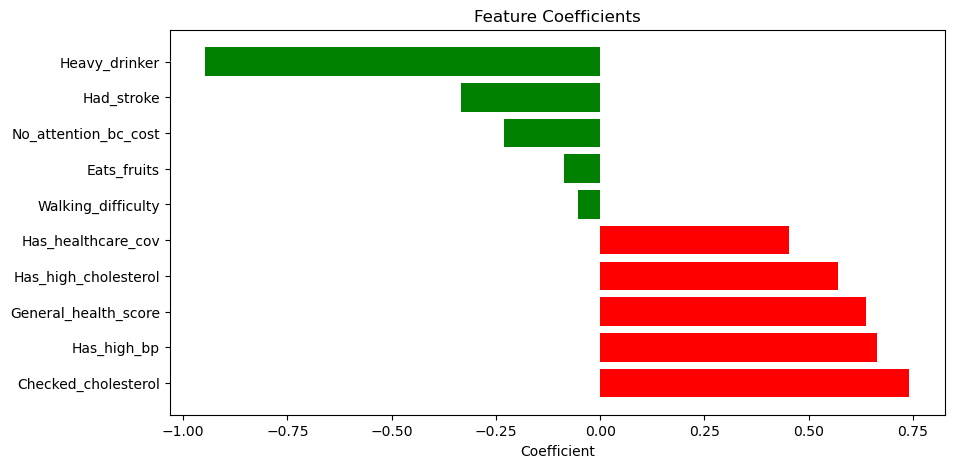

In [18]:
# Create a visualisation:
# Assign colors based on 'Coefficient' values
colors = ['green' if x < 0 else 'red' for x in combined_coef['Coefficient']]

# Create barh plot
plt.figure(figsize=(10, 5))
plt.barh(combined_coef['Feature'], combined_coef['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Feature Coefficients')

# Add the values to the bars
for index, value in enumerate(combined_coef['Coefficient']):
    if value < 0:
        plt.text(value, index, f'{value:.2f}', va='center', ha='right', color='white')
    else:
        plt.text(value, index, f'{value:.2f}', va='center', ha='left', color='white')

# Show the plot
plt.show()

### 4a.6 Model Evaluation

In [19]:
# Create confusion matrix for logistic regression

# Get class predictions
y_pred = optimised_log_reg.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative Review", "Predicted Positive Review"],
    index=["True Negative Review", "True Positive Review"]
)

display(cf_df)

,Predicted Negative Review,Predicted Positive Review
True Negative Review,46744,17367
True Positive Review,3173,8820


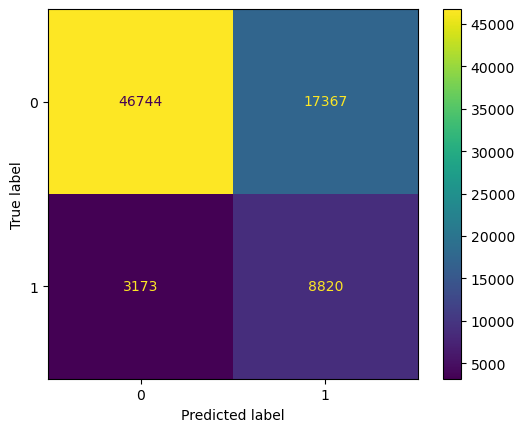

In [20]:
# Create visualisation of confusion matrix
ConfusionMatrixDisplay.from_estimator(optimised_log_reg, X_test, y_test);

Interpretation:

    The results of the confusion matrix are as follows:

    True Negative:  46,744

    False Positive: 17,367

    False Negative: 3,173

    True Positive:  8,820        

In [21]:
# Classification Report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.94      0.73      0.82     64111
           1       0.34      0.74      0.46     11993

    accuracy                           0.73     76104
   macro avg       0.64      0.73      0.64     76104
weighted avg       0.84      0.73      0.76     76104



### 4a.7 Observations

Looking at the errors:

For 0: 
- The precision of 0.94 means that 6% of the predicitons as not having diabetes were in fact positive.
- The recall of 0.73 means that 27% of the negative diagnosis were missed by the model as they were classified as being positive

For 1: 
- The precision of 0.34 means that 66% of the predicitons as having diabetes were in fact negative 
- The recall of 0.74 indicates that 26% of the diagnosis that were positive  were missed by the model and were classified as being negative for diabetes



The model shows a low F1 score of 0.46, indicating that the balance between recall and precision across the various classes could be improved. 

To improve the model's performance, it is recommended to closely examine instances where the sentiment was incorrectly predicted. 

Analysing these examples can help identify if there are specific health indicators that were mistakenly omitted, which could lead to more accurate predictions in the future.